In [2]:
import numpy as np
import pandas as pd
import os, glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import fft
from sklearn.model_selection import train_test_split

In [3]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
print(torch.__version__)

Using device: cuda
2.6.0+cu118


In [4]:
df = pd.read_csv('../regularset.csv') # reads in codes csv as a mutable df :-) contains message, ecl, code, dft cols


In [5]:
df = df.drop([0])
df['dft'] = df['dft ']

In [7]:
# parse a colomn with a 2d array of each qr code
df['code_array'] = df['code'].apply(lambda x: np.array([int(digit) for digit in x]).reshape(29, 29))
df['code_oned'] = df['code'].apply(lambda x: np.array([int(digit) for digit in x])) # adds a code_oned column to our df which parses our entries from strs to ints

In [6]:
arrays = np.stack(df['code_array'].values)
average_array = np.mean(arrays, axis=0)

fixedIndx = []
for i in range(29):
    for j in range(29):
        if average_array[i][j] == 1:
            fixedIndx.append((i, j))

fixedIndxAll = []
for i in range(29):
    for j in range(29):
        if average_array[i][j] == 1 or average_array[i][j] == 0:
            fixedIndxAll.append((i, j))





In [ ]:
nonFixed = []
for i in range(29):
    for j in range(29):
        if (i,j) not in fixedIndxAll:
            nonFixed.append((i,j))
nonFixed

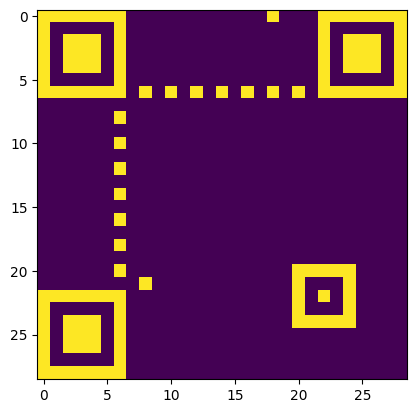

In [14]:
fixedQR = np.zeros((29,29))
for i,j in fixedIndx:
    fixedQR[i][j] = 1
fixedQR

plt.imshow(fixedQR)

In [7]:
# grabs a centered subarray of a given array with dimensions (2L+1) by (2L+1)
def get_centered_subarray(array, L):
    # old way -- 
    # L = (L * 2) + 1
    # start = center - (L // 2)
    # end = center + (L + 1) // 2
    n = array.shape[0]
    center = n // 2
    start = center - L
    end = center + 1 + L # start count after our center square
    # Adjust indices to stay within array bounds
    start = max(0, start)
    end = min(n, end)
    return array[start:end, start:end]

In [8]:
# function to split DFT into real and imaginary parts and reshape them
def split_dft(dft_str):
    complex_numbers = [complex(c.strip()) for c in dft_str.strip('()').split(')(')]
    real_part = np.array([c.real for c in complex_numbers])
    imag_part = np.array([c.imag for c in complex_numbers])
    return real_part, imag_part

# apply the function to each row
df['dft_real'], df['dft_imag'] = zip(*df['dft'].apply(split_dft))


KeyError: 'dft'

In [ ]:
# function to take dft string into complex tuple stored as (a, ib)
def combine_dft_full(dft_str):
    complex_numbers = [complex(c.strip()) for c in dft_str.strip('()').split(')(')]
    real_part = np.array([c.real for c in complex_numbers])
    # real_part = zero_pad_right(0.5, real_part)
    imag_part = np.array([c.imag for c in complex_numbers])
    # imag_part = zero_pad_right(0.5, imag_part)
    return np.append(real_part, imag_part)

df['dft_stacked'] = df['dft'].apply(combine_dft_full)

In [ ]:
fixed_fft = fft.fft2(fixedQR)

In [ ]:
flat = fixed_fft.copy().flatten() # flatten fixed 

# subtracts flattened fixed qr fft from flattened qr fft
def adjust(stacked):
    copy = stacked.copy()
    for i in range(841): 
        copy[i] -= flat[i].real
        copy[i+841] -= flat[i].imag # imaginary numbers shifted by 841 (total len)
    return copy

df['adjusted'] = df['dft_stacked'].apply(adjust)

In [ ]:
def adjust_y(flat):
    new = np.array([flat[row * 29 + column] for row, column in nonFixed])
    return new

df['y_adjusted'] = df['code_oned'].apply(adjust_y)


In [ ]:
# Features (X) - DFT components
X = np.stack(df['adjusted'].values)  # Shape: (num_samples, 1682) - (flat) total input data

# Labels (y) - QR codes
y = np.stack(df['y_adjusted'].values)  # Shape: (num_samples, 841) - (flat)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # decide on a rseed of 42 and a set set of 20%

In [ ]:
class Model(nn.Module):
    def __init__(self, in_features, out_features):
        super(Model, self).__init__()
        input_size = ((((L*2)+1)**2)*2)  # Matches the tf.keras InputLayer
        output_size = 592  # Matches the final Dense(592) layer
        
        self.fc = nn.Linear(input_size, output_size)  # Single-layer


    def forward(self, x):
        x = self.fc(x)

        return x

In [ ]:
def evaluate_model(model, X_test, y_test, num_samples=5):
    """
    evaluates the trained model on the test set and displays a few samples with their predictions.

    parameters:
    - model: The trained TensorFlow/Keras model.
    - X_test: The input features for the test set (shape: (num_samples, 1682)).
    - y_test: The true labels for the test set (shape: (num_samples, 841)).
    - num_samples: The number of test samples to display.

    returns:
    - accuracy: The overall accuracy of the model on the test set.
    """
    # make predictions on the test set
    predictions = model.predict(X_test)
    
    # binarize the predictions (0 or 1)
    predictions_binarized = (predictions > 0.5).astype(np.int32)
    
    # calculate accuracy
    correct_predictions = np.sum(predictions_binarized == y_test)
    total_elements = y_test.size
    accuracy = correct_predictions / total_elements
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

        
    return accuracy

In [ ]:
df['dft_rolled'] = df['adjusted'].apply(lambda x: np.roll(x.reshape(29,29,2), shift=(14, 14), axis=(0, 1)))

In [12]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Define Model Class
class Model(nn.Module):
    def __init__(self, L):
        super(Model, self).__init__()
        qr_size = 841
        latent_size = ((((L*2)+1)**2)*2)  # Adjusts input size for L
        output_size = 841  # Matches TensorFlow model
        self.fc1 = nn.Linear(qr_size, latent_size)
        self.fc2 = nn.Linear(latent_size, qr_size)

    def forward(self, x):
        return self.fc2(self.fc1(x))  # No activation for regression

# Training Loop
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

def evaluate_model(model, X_test, y_test, num_samples=5):
    """
    Evaluates the trained PyTorch model on the test set and displays a few samples with their predictions.

    Parameters:
    - model: The trained PyTorch model.
    - X_test: The input features for the test set (shape: (num_samples, 1682)).
    - y_test: The true labels for the test set (shape: (num_samples, 841)).
    - num_samples: The number of test samples to display.

    Returns:
    - accuracy: The overall accuracy of the model on the test set.
    """
    
    # Ensure model is in evaluation mode
    model.eval()

    # Convert test data to PyTorch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    with torch.no_grad():  # No gradient calculation needed
        predictions = model(X_test_tensor)  # Get model predictions

    # Apply threshold to binarize (0 or 1)
    predictions_binarized = (predictions > 0.5).int()

    # Compute accuracy
    correct_predictions = (predictions_binarized == y_test_tensor).sum().item()
    total_elements = y_test_tensor.numel()
    accuracy = correct_predictions / total_elements

    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Device Setup (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Main Loop Over L Values
L = 10
stat = []
for L in range(10, 0, -1):
    # Convert features to numpy arrays
    X = np.stack(df['code_oned'].values)  # Shape: (num_samples, ((L*2)+1)*2)
    y = np.stack(df['code_oned'].values)  # Assuming `df['target']` contains labels

    print(X.shape)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize Model, Optimizer, and Loss Function
    model = Model(L).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()  # Assuming a regression task

    # Train Model
    train_model(model, train_loader, criterion, optimizer, epochs=25)

    # Evaluate Model
    accuracy = evaluate_model(model, X_test, y_test)
    stat.append((L, accuracy))

    print(stat)


(59999, 841)
Epoch 1/25, Loss: 0.2644
Epoch 2/25, Loss: 0.1886
Epoch 3/25, Loss: 0.1843
Epoch 4/25, Loss: 0.1813
Epoch 5/25, Loss: 0.1781
Epoch 6/25, Loss: 0.1771
Epoch 7/25, Loss: 0.1782
Epoch 8/25, Loss: 0.1816
Epoch 9/25, Loss: 0.1717
Epoch 10/25, Loss: 0.1754
Epoch 11/25, Loss: 0.1747
Epoch 12/25, Loss: 0.1760
Epoch 13/25, Loss: 0.1743
Epoch 14/25, Loss: 0.1718
Epoch 15/25, Loss: 0.1756
Epoch 16/25, Loss: 0.1717
Epoch 17/25, Loss: 0.1686
Epoch 18/25, Loss: 0.1705
Epoch 19/25, Loss: 0.1643
Epoch 20/25, Loss: 0.1685
Epoch 21/25, Loss: 0.1665
Epoch 22/25, Loss: 0.1642
Epoch 23/25, Loss: 0.1645
Epoch 24/25, Loss: 0.1623
Epoch 25/25, Loss: 0.1653
Test Accuracy: 72.19%
[(10, 0.7218579072532699)]
(59999, 841)
Epoch 1/25, Loss: 0.2841
Epoch 2/25, Loss: 0.1951
Epoch 3/25, Loss: 0.1870
Epoch 4/25, Loss: 0.1797
Epoch 5/25, Loss: 0.1817
Epoch 6/25, Loss: 0.1775
Epoch 7/25, Loss: 0.1767
Epoch 8/25, Loss: 0.1763
Epoch 9/25, Loss: 0.1766
Epoch 10/25, Loss: 0.1752
Epoch 11/25, Loss: 0.1750
Epoch 1

In [8]:
#fixed L

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Define Model Class
# Define Model Class
class Model(nn.Module):
    def __init__(self, L):
        super(Model, self).__init__()
        qr_size = 841
        latent_size = ((((L*2)+1)**2)*2)  # Adjusts input size for L
        output_size = 841  # Matches TensorFlow model
        self.fc1 = nn.Linear(qr_size, latent_size)
        self.fc2 = nn.Linear(latent_size, qr_size)

    def forward(self, x):
        return self.fc2(self.fc1(x))  # No activation for regression


# Training Loop (Records Accuracy Every 5 Epochs)
def train_model(model, train_loader, criterion, optimizer, X_test, y_test, epochs=25):
    model.train()
    stat = []  # Store accuracy every 5 epochs
    
    for epoch in range(1, epochs + 1):
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        # Evaluate every 5 epochs
        if epoch % 5 == 0:
            accuracy = evaluate_model(model, X_test, y_test)
            stat.append((epoch, accuracy))
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.4f}")

    return stat

# Evaluation Function
def evaluate_model(model, X_test, y_test):
    model.eval()
    
    # Convert to PyTorch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    with torch.no_grad():
        predictions = model(X_test_tensor)
    
    # Binarize predictions (threshold at 0.5)
    predictions_binarized = (predictions > 0.5).int()

    # Compute accuracy
    correct_predictions = (predictions_binarized == y_test_tensor).sum().item()
    total_elements = y_test_tensor.numel()
    accuracy = correct_predictions / total_elements

    return accuracy

# Device Setup (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Fixed L at 5**
L = 5

# Convert features to numpy arrays
X = np.stack(df['code_oned'].values)  # Shape: (num_samples, ((L*2)+1)*2)
y = np.stack(df['code_oned'].values)  # Assuming `df['target']` contains labels

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize Model, Optimizer, and Loss Function
model = Model(L).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Assuming a regression task

# Train and Collect Accuracy Every 5 Epochs
stat = train_model(model, train_loader, criterion, optimizer, X_test, y_test, epochs=5000)

print("Final Accuracy Stats:", stat)


Epoch 5/5000, Loss: 0.1794, Test Accuracy: 0.6826
Epoch 10/5000, Loss: 0.1769, Test Accuracy: 0.6891
Epoch 15/5000, Loss: 0.1789, Test Accuracy: 0.6943
Epoch 20/5000, Loss: 0.1745, Test Accuracy: 0.6992
Epoch 25/5000, Loss: 0.1683, Test Accuracy: 0.7038
Epoch 30/5000, Loss: 0.1679, Test Accuracy: 0.7083
Epoch 35/5000, Loss: 0.1725, Test Accuracy: 0.7127
Epoch 40/5000, Loss: 0.1658, Test Accuracy: 0.7170
Epoch 45/5000, Loss: 0.1644, Test Accuracy: 0.7210
Epoch 50/5000, Loss: 0.1618, Test Accuracy: 0.7248
Epoch 55/5000, Loss: 0.1574, Test Accuracy: 0.7283
Epoch 60/5000, Loss: 0.1587, Test Accuracy: 0.7317
Epoch 65/5000, Loss: 0.1613, Test Accuracy: 0.7349
Epoch 70/5000, Loss: 0.1577, Test Accuracy: 0.7380
Epoch 75/5000, Loss: 0.1529, Test Accuracy: 0.7410
Epoch 80/5000, Loss: 0.1519, Test Accuracy: 0.7437
Epoch 85/5000, Loss: 0.1516, Test Accuracy: 0.7464
Epoch 90/5000, Loss: 0.1492, Test Accuracy: 0.7490
Epoch 95/5000, Loss: 0.1516, Test Accuracy: 0.7514
Epoch 100/5000, Loss: 0.1491, Te

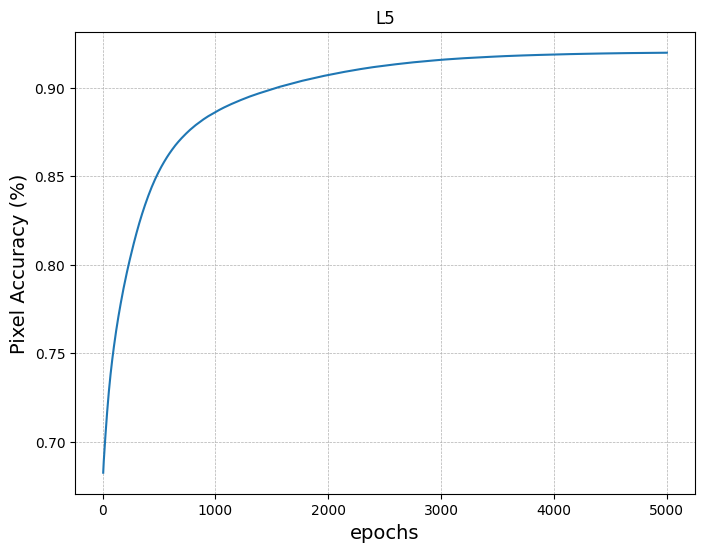

In [9]:
#l graph
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlabel('epochs', fontsize=14)
ax.set_ylabel('Pixel Accuracy (%)', fontsize=14)
ax.set_title('L5')
ax.plot([st[0] for st in stat], [st[1] for st in stat]) # plots accuracy vs L -- we can add labels later!

In [10]:
fig.savefig('Autoencoder_1_layer_torch_L5_5000.png', dpi=300)

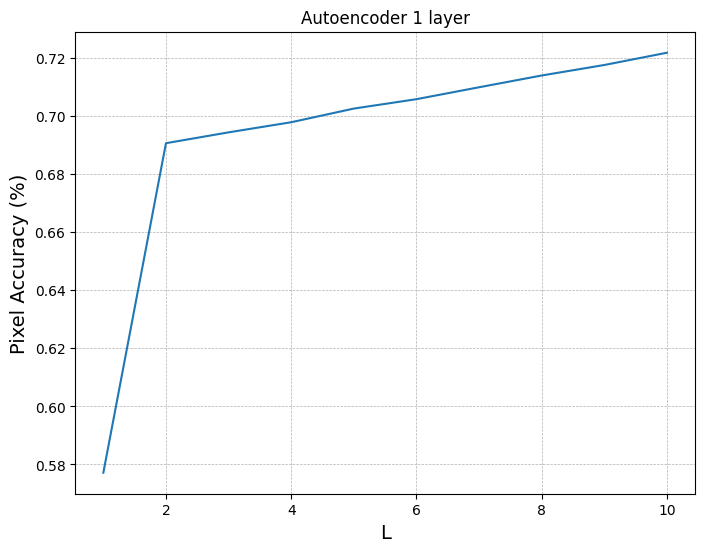

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlabel('L', fontsize=14)
ax.set_ylabel('Pixel Accuracy (%)', fontsize=14)
ax.set_title('Autoencoder 1 layer')
ax.plot([st[0] for st in stat], [st[1] for st in stat]) # plots accuracy vs L -- we can add labels later!

In [13]:
stat = [(10, 0.7218579072532699), (9, 0.7176319857312723), (8, 0.7140148632580262), (7, 0.7099592746730083), (6, 0.7058540428061831), (5, 0.7026167261196987), (4, 0.6979101268331351), (3, 0.6944241973840666), (2, 0.6906887633769322), (1, 0.5771642885453825)]